In [1]:
import os
import pandas as pd
import numpy as np

from skimage.io import imread, imsave
import matplotlib.pyplot as plt
from cellpose import models, io

In [2]:
io.logger_setup()
model = models.Cellpose(model_type='nuclei')

2024-06-13 14:55:28,751 [INFO] WRITING LOG OUTPUT TO C:\Users\woikaka\.cellpose\run.log
2024-06-13 14:55:28,752 [INFO] 
cellpose version: 	3.0.5 
platform:       	win32 
python version: 	3.10.6 
torch version:  	2.0.0+cpu
2024-06-13 14:55:28,753 [INFO] >>>> using CPU
2024-06-13 14:55:28,757 [INFO] >> nuclei << model set to be used
2024-06-13 14:55:29,041 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)


In [8]:
from scipy.stats import pearsonr

In [12]:
input_dir = './HeLa_Hoechst_GM130_CENP-F'
data = []

def manders_overlap(I1, I2):
    overlap = np.sum(I1 * I2)
    M1 = overlap / np.sum(I1)
    M2 = overlap / np.sum(I2)
    return M1, M2

output_dir = 'figures'
os.makedirs(output_dir, exist_ok=True)

for file in os.listdir(input_dir):
    img = imread(os.path.join(input_dir, file))
    # print(img.shape)
    dapi = img[:,:,0]
    hoechst = img[:,:,1]
    cenpf = img[:,:,2]
    masks, flows, styles, diams = model.eval(dapi, diameter=None)
    output = file.split('.')[0]
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(dapi, cmap='gray')
    ax[0].set_title('DAPI Channel')
    ax[1].imshow(masks, cmap='nipy_spectral')
    ax[1].set_title('Cell Masks')
    # plt.show()
    plt.savefig(os.path.join(output_dir, f'{output}.pdf'), format='pdf')
    plt.close(fig)   
    cell_nums = np.max(masks)
    nucleus = np.where(masks > 0, 1, 0)
    fluorescence_intensity_hoechst = hoechst * nucleus
    fluorescence_intensity_cenpf = cenpf * nucleus
    average_hoechst = fluorescence_intensity_hoechst.sum() / cell_nums
    average_cenpf = fluorescence_intensity_cenpf.sum() / cell_nums
    M1, M2 = manders_overlap(fluorescence_intensity_hoechst, fluorescence_intensity_cenpf)
    data.append([file, fluorescence_intensity_hoechst.sum(), 
                 fluorescence_intensity_cenpf.sum(), average_hoechst, 
                 average_cenpf, cell_nums, M1, M2])
df = pd.DataFrame(data, columns=['File', 'Fluorescence_Intensity_Hoechst', 
                                 'Fluorescence_Intensity_CENPF', 'Average_Hoechst', 
                                 'Average_CENPF', 'Cell_Nums', 'Manders_M1', 'Manders_M2'])
df.to_csv('Results.csv', index=False)
hoechst_values = df['Fluorescence_Intensity_Hoechst']
cenpf_values = df['Fluorescence_Intensity_CENPF']
pearson_corr, _ = pearsonr(hoechst_values, cenpf_values)
print(f'Pearson correlation coefficient: {pearson_corr}')

2024-06-13 15:25:49,389 [INFO] channels set to [0, 0]
2024-06-13 15:25:49,391 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2024-06-13 15:26:01,467 [INFO] estimated cell diameter(s) in 12.08 sec
2024-06-13 15:26:01,468 [INFO] >>> diameter(s) = 
2024-06-13 15:26:01,468 [INFO] [ 43.92 ]
2024-06-13 15:26:01,469 [INFO] ~~~ FINDING MASKS ~~~
2024-06-13 15:26:06,559 [INFO] >>>> TOTAL TIME 17.17 sec
2024-06-13 15:26:06,937 [INFO] channels set to [0, 0]
2024-06-13 15:26:06,938 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2024-06-13 15:26:22,952 [INFO] estimated cell diameter(s) in 16.01 sec
2024-06-13 15:26:22,953 [INFO] >>> diameter(s) = 
2024-06-13 15:26:22,954 [INFO] [ 46.08 ]
2024-06-13 15:26:22,954 [INFO] ~~~ FINDING MASKS ~~~
2024-06-13 15:26:28,210 [INFO] >>>> TOTAL TIME 21.27 sec
2024-06-13 15:26:28,568 [INFO] channels set to [0, 0]
2024-06-13 15:26:28,569 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2024-06-13 15:26:41,502 [INFO] estimated cell diameter(s) in 12.93 sec
2024-06-13 15:26:41,50

In [13]:
import os
import pandas as pd
import tifffile

input_dir = './HeLa_Hoechst_GM130_CENP-F'
output_csv = 'tif_metadata.csv'

metadata_list = []

for file in os.listdir(input_dir):
    if file.endswith('.tif') or file.endswith('.tiff'):
        filepath = os.path.join(input_dir, file)
        
        with tifffile.TiffFile(filepath) as tif:
            image = tif.asarray()
            image_description = tif.pages[0].description if tif.pages[0].description else 'N/A'
            datetime = tif.pages[0].tags.get('DateTime').value if 'DateTime' in tif.pages[0].tags else 'N/A'
            
            metadata = {
                'File': file,
                'Width': image.shape[1],
                'Height': image.shape[0],
                'Channels': image.shape[2] if len(image.shape) == 3 else 1,
                'DataType': image.dtype,
                'Description': image_description,
                'DateTime': datetime
            }
            metadata_list.append(metadata)

df = pd.DataFrame(metadata_list)
df.to_csv(output_csv, index=False)

print(f'Metadata has been saved to {output_csv}')


Metadata has been saved to tif_metadata.csv


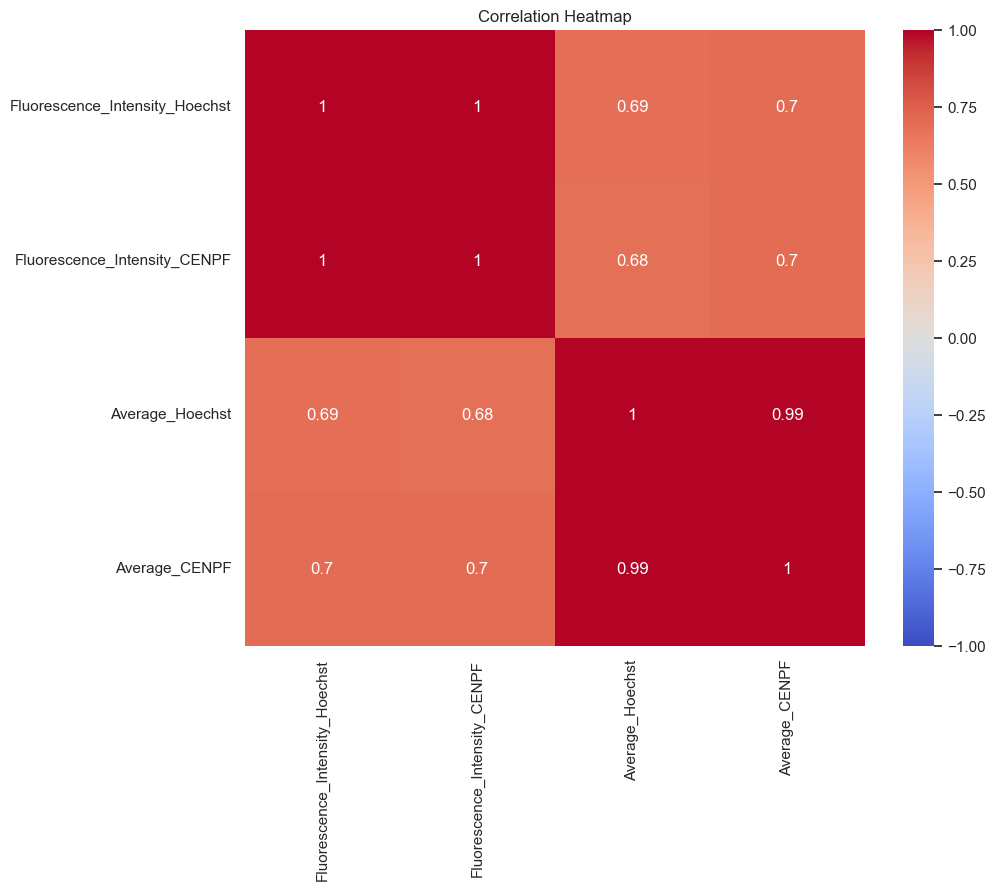

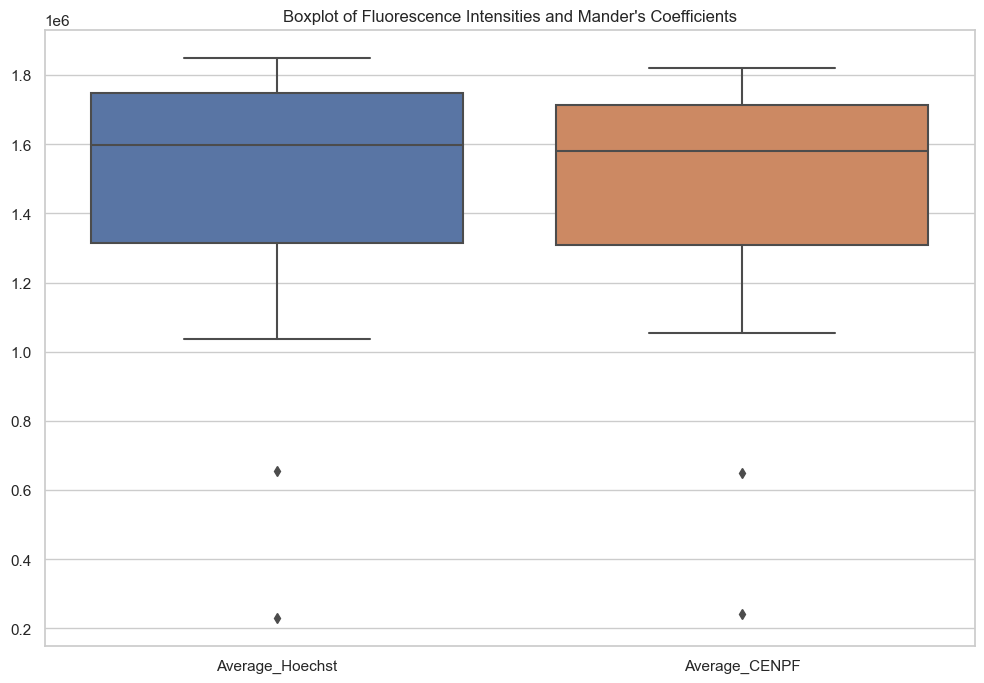

C:\Users\woikaka\AppData\Local\Temp\ipykernel_16244\2688103265.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[1]
C:\Users\woikaka\AppData\Local\Temp\ipykernel_16244\2688103265.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = model.params[0]


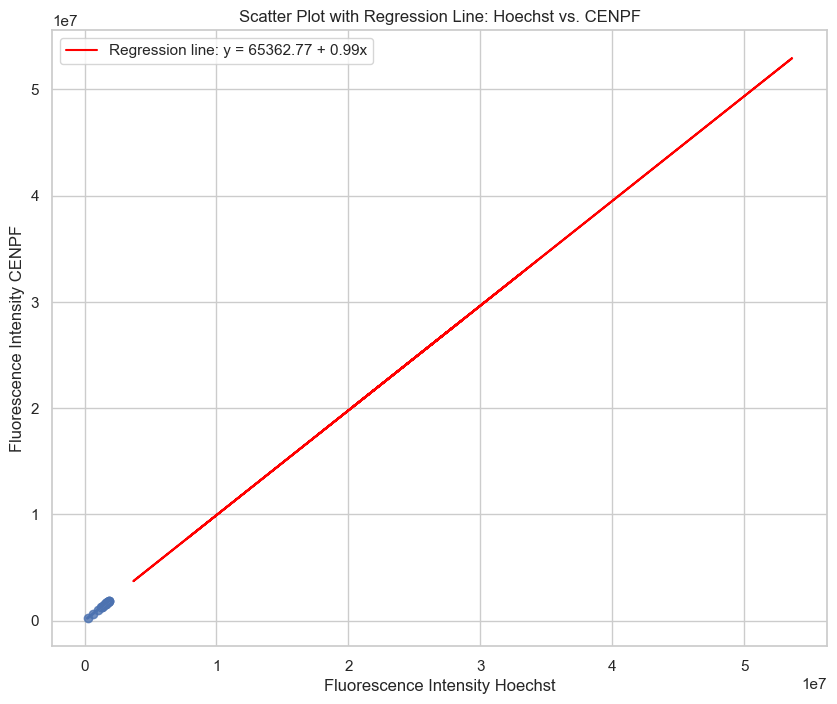

                                 OLS Regression Results                                 
Dep. Variable:     Fluorescence_Intensity_CENPF   R-squared:                       0.995
Model:                                      OLS   Adj. R-squared:                  0.995
Method:                           Least Squares   F-statistic:                     3636.
Date:                          Thu, 13 Jun 2024   Prob (F-statistic):           3.17e-22
Time:                                  15:42:03   Log-Likelihood:                -298.54
No. Observations:                            20   AIC:                             601.1
Df Residuals:                                18   BIC:                             603.1
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------

d:\conda\envs\test\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


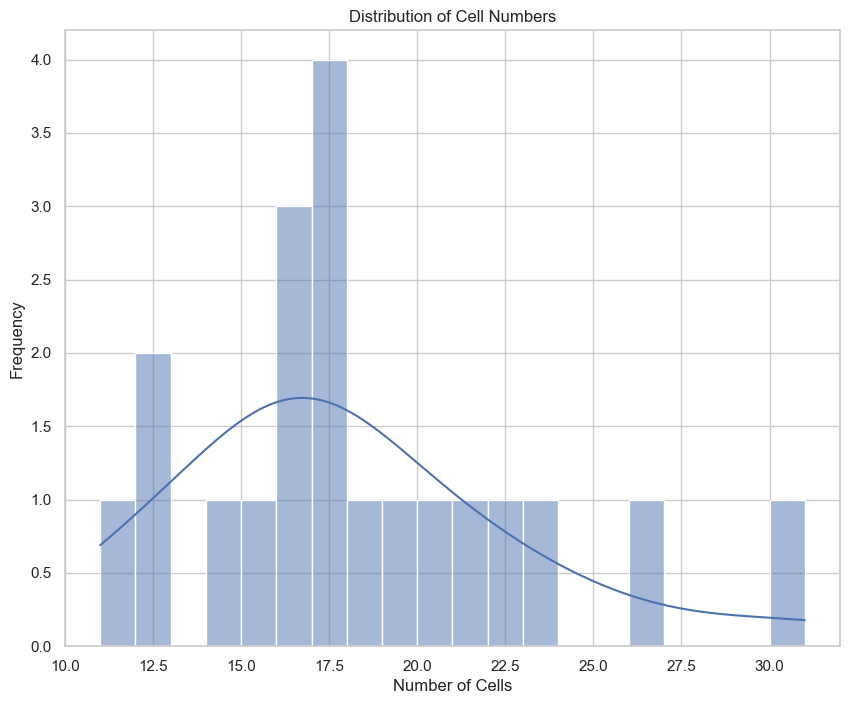

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

df = pd.read_csv('Results.csv')
sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))
heatmap_data = df[['Fluorescence_Intensity_Hoechst', 'Fluorescence_Intensity_CENPF', 'Average_Hoechst', 'Average_CENPF']]
sns.heatmap(heatmap_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.savefig('./figures/correlation_heatmap.pdf')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=df[['Average_Hoechst', 'Average_CENPF']])
plt.title('Boxplot of Fluorescence Intensities and Mander\'s Coefficients')
plt.savefig('./figures/boxplot_fluorescence_manders.pdf')
plt.show()

plt.figure(figsize=(10, 8))
sns.regplot(x='Average_Hoechst', y='Average_Hoechst', data=df)
plt.xlabel('Fluorescence Intensity Hoechst')
plt.ylabel('Fluorescence Intensity CENPF')
plt.title('Scatter Plot with Regression Line: Hoechst vs. CENPF')
X = df['Fluorescence_Intensity_Hoechst']
Y = df['Fluorescence_Intensity_CENPF']
X = sm.add_constant(X)  # 添加常数项以计算截距
model = sm.OLS(Y, X).fit()
regression_line = model.predict(X)
slope = model.params[1]
intercept = model.params[0]
plt.plot(X.iloc[:, 1], regression_line, color='red', label=f'Regression line: y = {intercept:.2f} + {slope:.2f}x')
plt.legend()
plt.savefig('./figures/scatterplot_hoechst_cenpf_with_regression.pdf')
plt.show()
print(model.summary())

plt.figure(figsize=(10, 8))
sns.histplot(df['Cell_Nums'], bins=20, kde=True)
plt.xlabel('Number of Cells')
plt.ylabel('Frequency')
plt.title('Distribution of Cell Numbers')
plt.savefig('./figures/histogram_cell_nums.pdf')
plt.show()
